In [1]:
%matplotlib inline
from sklearn import cross_validation
import numpy as np
import os
import pandas as pd
from WavefrontPSF.decamutil_cpd import decaminfo
dec = decaminfo()

path = '/Users/cpd/Desktop/ComboMeshes-old/'
path_out = '/Users/cpd/Desktop/ComboMeshes2/'
mesh_name = 'Science-20140212s2-v1i2_All'#'Science-20121120s1-v1i2_All'
dTrains = []
dTests = []
dVals = []
fileTitle = 'z{0}'.format(4) + 'Mesh_' + mesh_name
if os.path.exists(path_out + 'Mesh_' + mesh_name + '_val.dat'):
    
    trainName = path_out + 'Mesh_' + mesh_name + '_train.dat'
    dTrains = pd.read_csv(trainName)
    testName = path_out + 'Mesh_' + mesh_name + '_test.dat'
    dTests = pd.read_csv(testName)
    valName = path_out + 'Mesh_' + mesh_name + '_val.dat'
    dVals = pd.read_csv(valName)

    
else:
    fileTitle = 'z{0}'.format(4) + 'Mesh_' + mesh_name
    fileName = path + fileTitle + '.dat'
    dataPoints = np.loadtxt(fileName, dtype=[('Sensor','|S3'),('x','float'),('y','float'),('z','float'),('w','float')])
    dTrain_base_indx, dTest_indx = cross_validation.train_test_split(np.arange(len(dataPoints)))
    # divide the dTrain_base_indx into dTrain_indx and dVal_indx
    dTrain_indx, dVal_indx = cross_validation.train_test_split(np.arange(len(dTrain_base_indx)))
    
    sensor = dataPoints['Sensor']
    # convert sensor to chip id
    x = dataPoints['x']
    y = dataPoints['y']
    
    columns = ['x', 'y', 'ccdnum']
    ccdnum = [dec.infoDict[sensor_i]['CCDNUM']
              for sensor_i in sensor]
    coords = np.array([x, y, ccdnum]).T
    dTests = coords[dTest_indx]
    dTrains = coords[dTrain_base_indx][dTrain_indx]
    dVals = coords[dTrain_base_indx][dVal_indx]
    for zi in range(4, 12):
        fileTitle = 'z{0}'.format(zi) + 'Mesh_' + mesh_name
        fileName = path + fileTitle + '.dat'
        zkey = 'z{0}'.format(zi)
        wkey = 'w{0}'.format(zi)
        columns += [zkey, wkey]
        
        dataPoints = np.loadtxt(fileName, dtype=[('Sensor','|S3'),('x','float'),('y','float'),
                                                 (zkey, 'float'),(wkey,'float')])

        dTests = np.hstack((dTests,
                            dataPoints[zkey][dTest_indx][:, np.newaxis],
                            dataPoints[wkey][dTest_indx][:, np.newaxis]))
        dTrains = np.hstack((dTrains,
                            dataPoints[zkey][dTrain_base_indx][dTrain_indx][:, np.newaxis],
                            dataPoints[wkey][dTrain_base_indx][dTrain_indx][:, np.newaxis]))
        dVals = np.hstack((dVals,
                            dataPoints[zkey][dTrain_base_indx][dVal_indx][:, np.newaxis],
                            dataPoints[wkey][dTrain_base_indx][dVal_indx][:, np.newaxis]))
        # save!
        trainName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_train.dat'
        np.savetxt(trainName, dataPoints[dTrain_base_indx][dTrain_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])
        testName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_test.dat'
        np.savetxt(testName, dataPoints[dTest_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])
        valName = path_out + 'z{0}'.format(zi) + 'Mesh_' + mesh_name + '_val.dat'
        np.savetxt(valName, dataPoints[dTrain_base_indx][dVal_indx],
                   fmt=['%s', '%f', '%f', '%f', '%f'])

    # save!
    trainName = path_out + 'Mesh_' + mesh_name + '_train.dat'
    df = pd.DataFrame(dTrains, columns=columns)
    df.to_csv(trainName)
    dTrains = df
    testName = path_out + 'Mesh_' + mesh_name + '_test.dat'
    df = pd.DataFrame(dTests, columns=columns)
    df.to_csv(testName)
    dTests = df
    valName = path_out + 'Mesh_' + mesh_name + '_val.dat'
    df = pd.DataFrame(dVals, columns=columns)
    df.to_csv(valName)
    dVals = df

## look at old donutana interpolation (aaron's code)

In [2]:
if os.path.exists(path_out + 'Mesh_' + mesh_name + '_train_DA.dat'):
    trainName = path_out + 'Mesh_' + mesh_name + '_train_DA.dat'
    dTrains_FPF = pd.read_csv(trainName)
    testName = path_out + 'Mesh_' + mesh_name + '_test_DA.dat'
    dTests_FPF = pd.read_csv(testName)
    valName = path_out + 'Mesh_' + mesh_name + '_val_DA.dat'
    dVals_FPF = pd.read_csv(valName)
else:
    from WavefrontPSF.focal_plane_fit import FocalPlaneFit

    FPF = FocalPlaneFit(path_mesh=path_out, mesh_name=mesh_name + '_train')
    column_names = ['x', 'y', 'ccdnum']

    # dTests
    dTests_FPF = dTests[column_names].copy()
    ccdnums = dTests_FPF['ccdnum'].unique()
    for i, zi in enumerate(xrange(4, 12)):
        dTests_FPF['z{0}'.format(zi)] = 0
    for ccdnum in ccdnums:
        sensor = dec.ccddict[ccdnum]
        conds = dTests_FPF['ccdnum'] == ccdnum
        xs = dTests_FPF['x'][conds]
        ys = dTests_FPF['y'][conds]
        for i, zi in enumerate(xrange(4, 12)):
            zernike = FPF.da.meshDict['z{0}Mesh'.format(zi)].doInterp(sensor, xs, ys)
            dTests_FPF['z{0}'.format(zi)][conds] = zernike
    # now save the FPF predictions
    testName = path_out + 'Mesh_' + mesh_name + '_test_DA.dat'
    dTests_FPF.to_csv(testName)

    # dTrains
    dTrains_FPF = dTrains[column_names].copy()
    ccdnums = dTrains_FPF['ccdnum'].unique()
    for i, zi in enumerate(xrange(4, 12)):
        dTrains_FPF['z{0}'.format(zi)] = 0
    for ccdnum in ccdnums:
        sensor = dec.ccddict[ccdnum]
        conds = dTrains_FPF['ccdnum'] == ccdnum
        xs = dTrains_FPF['x'][conds]
        ys = dTrains_FPF['y'][conds]
        for i, zi in enumerate(xrange(4, 12)):
            zernike = FPF.da.meshDict['z{0}Mesh'.format(zi)].doInterp(sensor, xs, ys)
            dTrains_FPF['z{0}'.format(zi)][conds] = zernike
    # now save the FPF predictions
    trainName = path_out + 'Mesh_' + mesh_name + '_train_DA.dat'
    dTrains_FPF.to_csv(trainName)

    # dVals
    dVals_FPF = dVals[column_names].copy()
    ccdnums = dVals_FPF['ccdnum'].unique()
    for i, zi in enumerate(xrange(4, 12)):
        dVals_FPF['z{0}'.format(zi)] = 0
    for ccdnum in ccdnums:
        sensor = dec.ccddict[ccdnum]
        conds = dVals_FPF['ccdnum'] == ccdnum
        xs = dVals_FPF['x'][conds]
        ys = dVals_FPF['y'][conds]
        for i, zi in enumerate(xrange(4, 12)):
            zernike = FPF.da.meshDict['z{0}Mesh'.format(zi)].doInterp(sensor, xs, ys)
            dVals_FPF['z{0}'.format(zi)][conds] = zernike
    # now save the FPF predictions
    valName = path_out + 'Mesh_' + mesh_name + '_val_DA.dat'
    dVals_FPF.to_csv(valName)

## try a couple of your own interpolants

In [35]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# find the best values using just one of the zernikes
X = np.vstack((dTrains['x'], dTrains['y'])).T
y = dTrains['z5'].values

# val
Xval = np.vstack((dVals['x'], dVals['y'])).T
yval = dVals['z5'].values

# test
Xtest = np.vstack((dTests['x'], dTests['y'])).T
ytest = dTests['z5'].values

# determine best hyperparameters using dVals
# for some reason this fails on distance weights?
parameter_grid = {#'weights': ['distance', 'uniform'],
                  'n_neighbors': range(30, 70, 5),#[5, 20, 50, 80, 150, 320],
                  'p': [1, 2],
                  }

knn = KNeighborsRegressor(weights='uniform', n_neighbors=5, p=1)

grid_search = GridSearchCV(knn, param_grid=parameter_grid)
grid_search.fit(Xval, yval)
clf = grid_search.best_estimator_
print(clf.get_params())
interp_kwargs = clf.get_params()
clf.fit(X, y)
ytest_guess = clf.predict(Xtest)

{'n_neighbors': 45, 'algorithm': 'auto', 'metric': 'minkowski', 'p': 1, 'weights': 'uniform', 'leaf_size': 30}


## Compare results

In [36]:
from WavefrontPSF_new.psf_interpolator import kNN_Interpolator
knn_uniform = kNN_Interpolator(dTrains, **interp_kwargs)
dTests_uniform = knn_uniform(dTests['x'], dTests['y'])
interp_kwargs['weights'] = 'distance'
knn_distance = kNN_Interpolator(dTrains, **interp_kwargs)
dTests_distance = knn_distance(dTests['x'], dTests['y'])

In [75]:
from WavefrontPSF_new.wavefront import Wavefront
num_bins=4
WF_truth = Wavefront(dTests, None, None)
WF_truth.reduce(num_bins=num_bins)

WF_FPF = Wavefront(dTests_FPF, None, None)
WF_FPF.reduce(num_bins=num_bins)

WF_uniform = Wavefront(dTests_uniform, None, None)
WF_uniform.reduce(num_bins=num_bins)

WF_distance = Wavefront(dTests_distance, None, None)
WF_distance.reduce(num_bins=num_bins)

WF_truth_FPF = Wavefront(None, None, None)
WF_truth_FPF.bins_x = WF_truth.bins_x
WF_truth_FPF.bins_y = WF_truth.bins_y
WF_truth_FPF.data = WF_truth.data - WF_FPF.data
WF_truth_FPF.data['x'] = WF_truth.data['x']
WF_truth_FPF.data['y'] = WF_truth.data['y']
WF_truth_FPF.reduce(num_bins=num_bins)

WF_truth_uniform = Wavefront(None, None, None)
WF_truth_uniform.bins_x = WF_truth.bins_x
WF_truth_uniform.bins_y = WF_truth.bins_y
WF_truth_uniform.data = WF_truth.data - WF_uniform.data
WF_truth_uniform.data['x'] = WF_truth.data['x']
WF_truth_uniform.data['y'] = WF_truth.data['y']
WF_truth_uniform.reduce(num_bins=num_bins)


WF_truth_distance = Wavefront(None, None, None)
WF_truth_distance.bins_x = WF_truth.bins_x
WF_truth_distance.bins_y = WF_truth.bins_y
WF_truth_distance.data = WF_truth.data - WF_distance.data
WF_truth_distance.data['x'] = WF_truth.data['x']
WF_truth_distance.data['y'] = WF_truth.data['y']
WF_truth_distance.reduce(num_bins=num_bins)


wflist = [[WF_truth, WF_FPF, WF_uniform, WF_distance],
          [None, WF_truth_FPF, WF_truth_uniform, WF_truth_distance]]

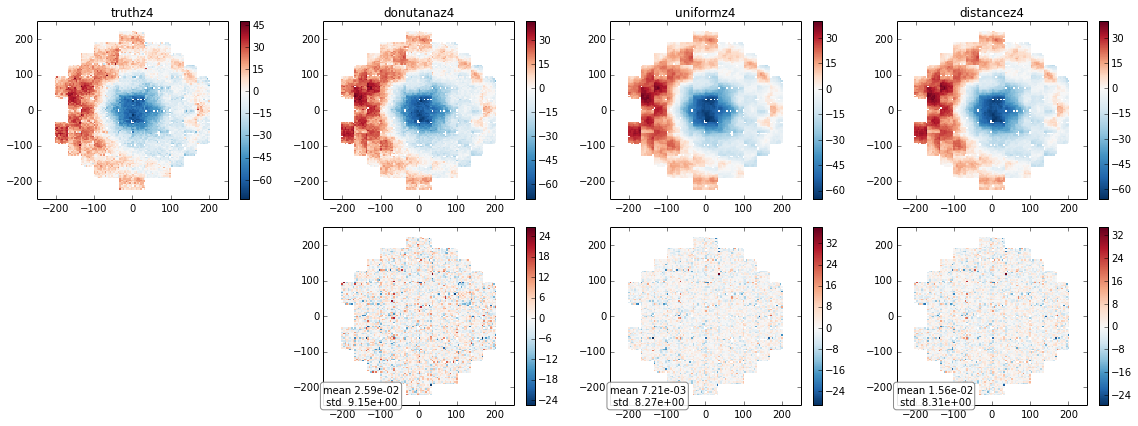

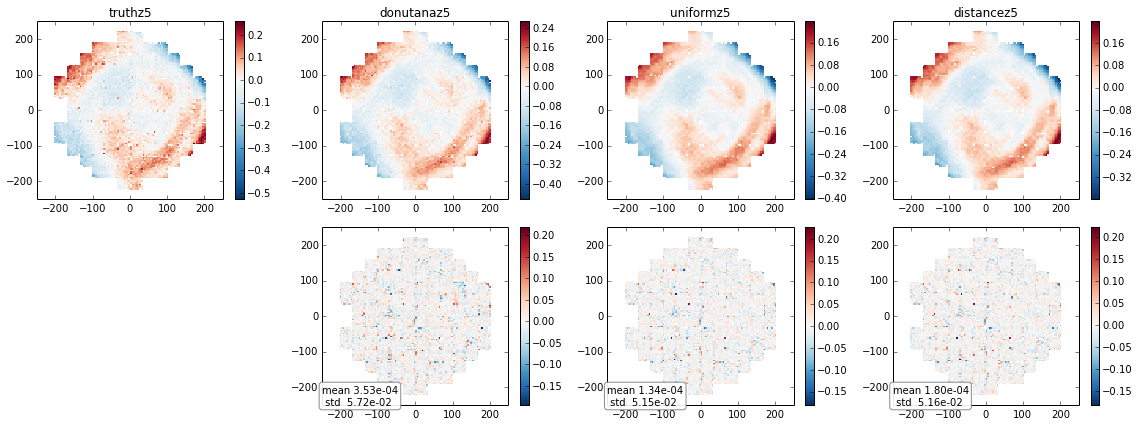

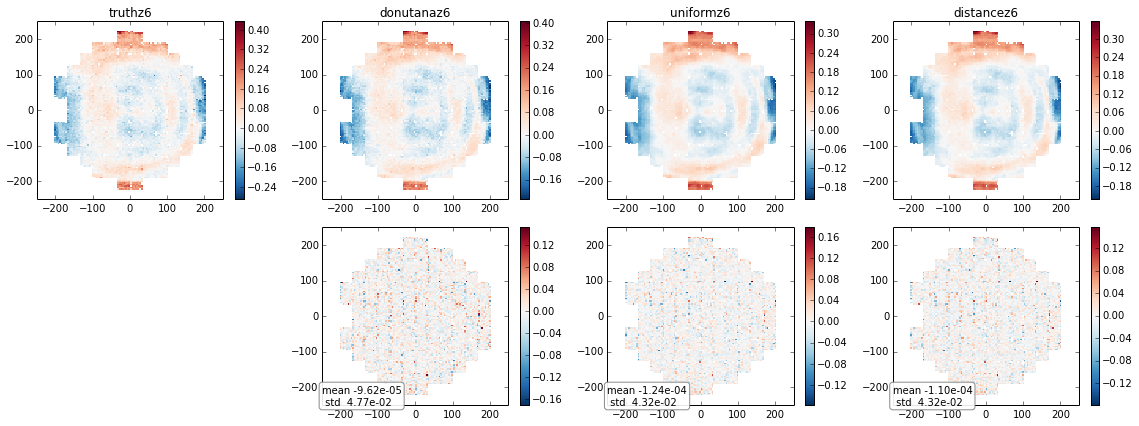

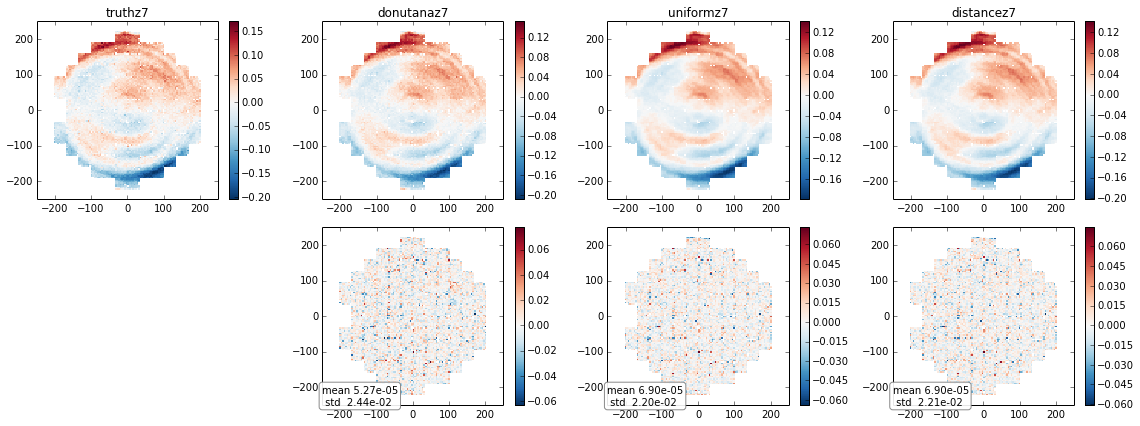

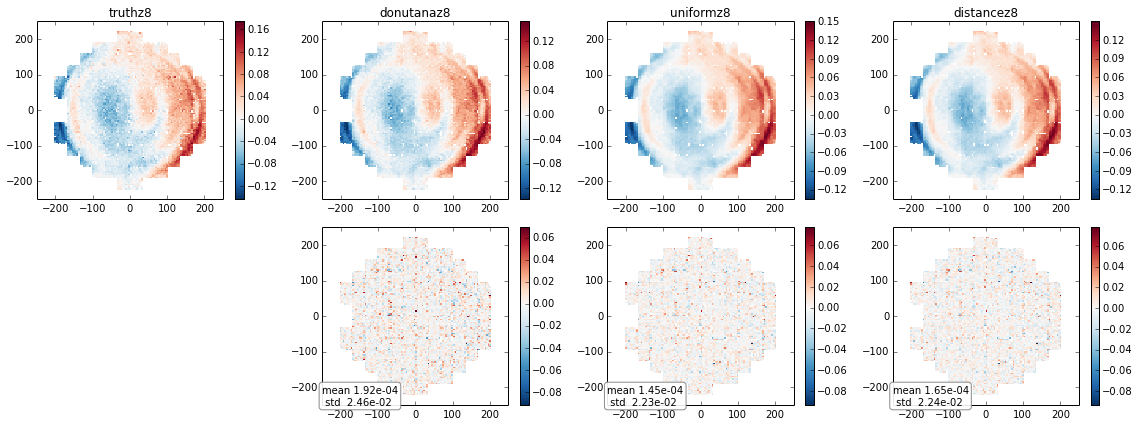

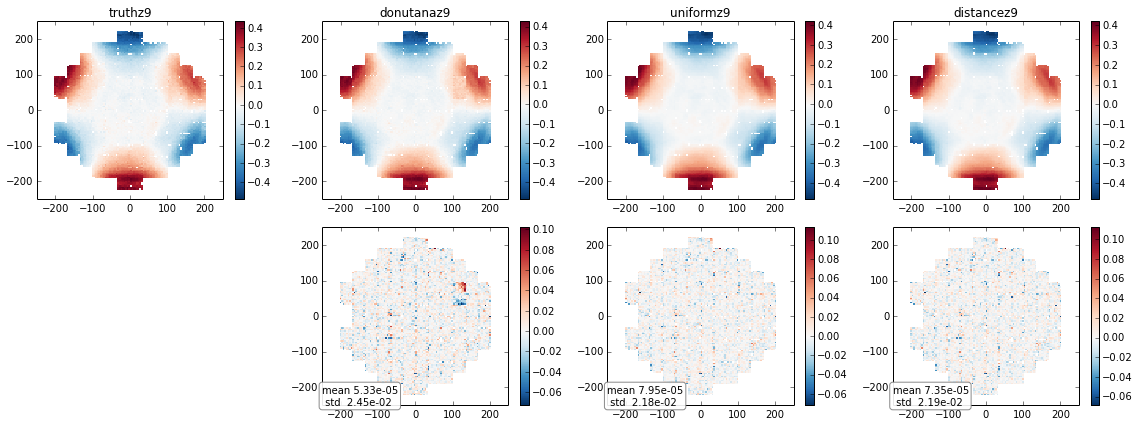

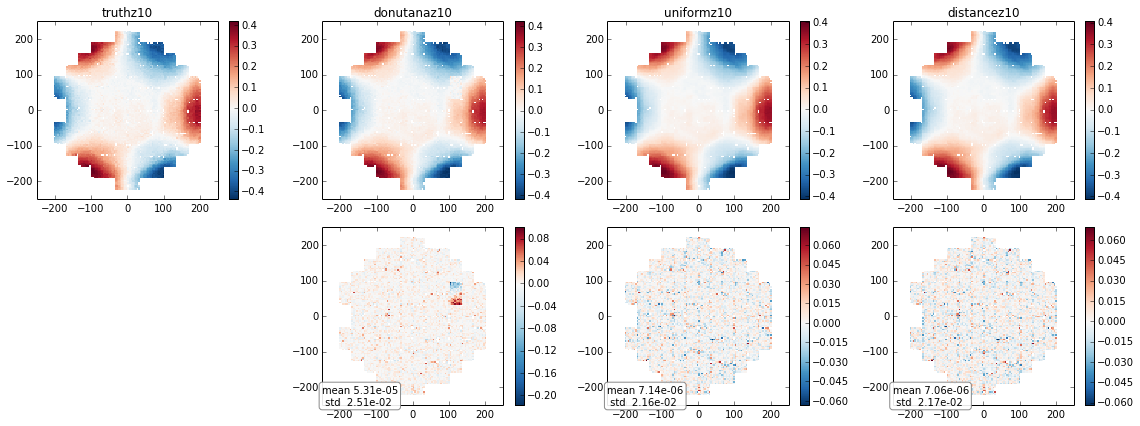

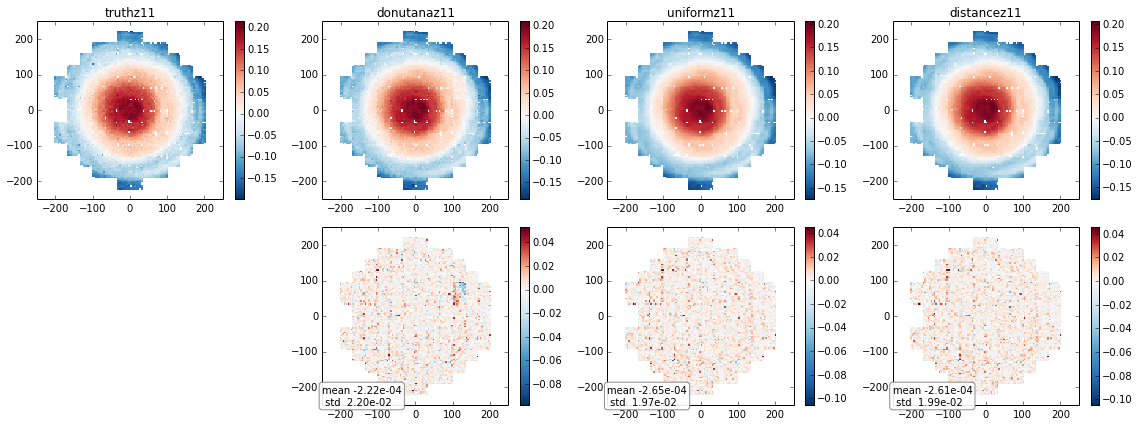

In [76]:
for keyi in range(4, 12):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=((3 + 1) * 4, 3 * 2))
    key = 'z{0}'.format(keyi)
    axtitles = ['truth', 'donutana', 'uniform', 'distance']
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
    for axi in range(2):
        for axj in range(4):
            if axi == 1 and axj == 0:
                continue
            elif axi == 2 and axj == 0:
                continue
            elif axi == 2:
                # plot histogram distributions
                wf = wflist[1][axj]
                ax = axes[axi, axj]
                ax.hist(wf.data[key][wf.data[key].notnull()], bins=1000, histtype='step')
            else:
                wf = wflist[axi][axj]
                ax = axes[axi, axj]
    #             ax.set_xlabel('$X$ [mm] (East)')
    #             ax.set_ylabel('$Y$ [mm] (South)')
                ax.set_xlim(-250, 250)
                ax.set_ylim(-250, 250)

                wf.plot_field(key, fig=fig, ax=ax)
                if axi == 0:
                    ax.set_title(axtitles[axj] + ' ' + key)
                else:
                    # axi == 1
                    text = 'mean {0:.2e}\n std  {1:.2e}'.format(wf.data[key].mean(), wf.data[key].std())
                    ax.text(-250, -250, text, bbox=bbox_props)


    plt.tight_layout()
    # turn off ax
    axes[1, 0].set_visible(False)
    # axes[2, 0].set_visible(False)